## Stage 1: Intuition through Interaction

Our goal: Find the **lowest point** using gradient descent!

### Step 1: Plot the function f(x) = x²

This is our simple curve – a "bowl" shape.

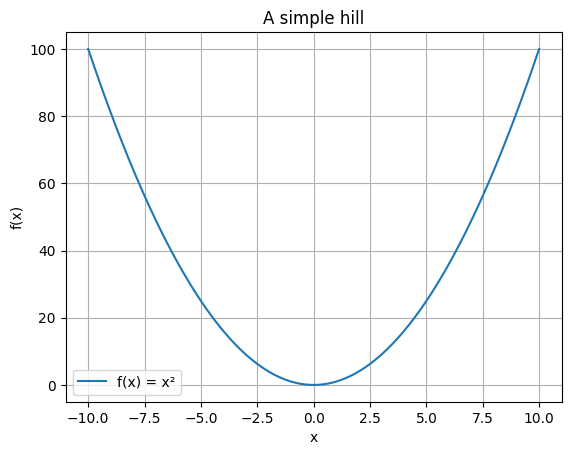

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 200)
f_x = x**2

plt.plot(x, f_x, label='f(x) = x²')
plt.title("A simple hill")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()


### Step 2: Plot the slope (derivative) f'(x) = 2x

The slope tells us **how steep the hill is** at any point.  
We'll plot the derivative to show this steepness.


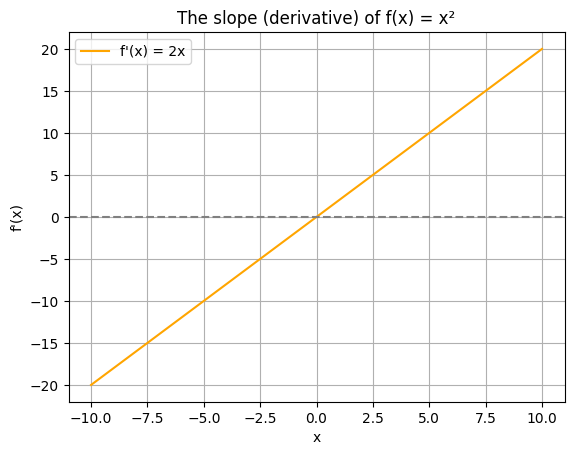

In [2]:
f_prime_x = 2 * x

plt.plot(x, f_prime_x, label="f'(x) = 2x", color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("The slope (derivative) of f(x) = x²")
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.grid(True)
plt.legend()
plt.show()



### Step 3: Visualize the curve and the slope on the same graph

This helps us understand how the slope behaves along the curve.


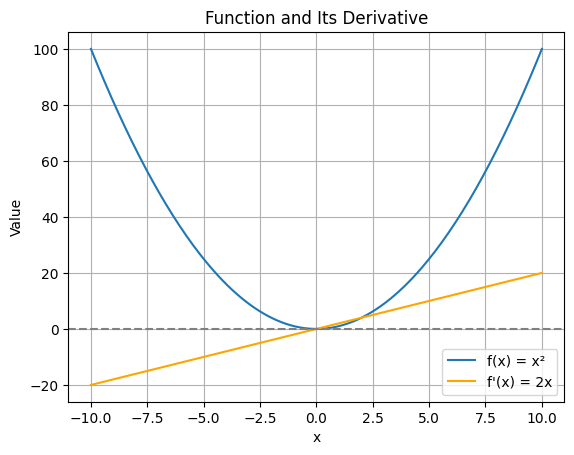

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 200)
f_x = x**2
f_prime_x = 2 * x

plt.plot(x, f_x, label='f(x) = x²')
plt.plot(x, f_prime_x, label="f'(x) = 2x", color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Function and Its Derivative")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


### Step 4: Add a slider to simulate a robot walking downhill

This simulates how gradient descent works – the robot uses the slope to step **downhill** toward the lowest point.


In [1]:
import ipywidgets as widgets
from IPython.display import display

def gradient_step(x_value):
    y = x_value**2
    slope = 2 * x_value
    step = x_value - 0.1 * slope  # one gradient step
    print(f"x: {x_value:.2f}, f(x): {y:.2f}, slope: {slope:.2f}, next x: {step:.2f}")

widgets.interact(gradient_step, x_value=widgets.FloatSlider(value=5, min=-10, max=10, step=0.1))


interactive(children=(FloatSlider(value=5.0, description='x_value', max=10.0, min=-10.0), Output()), _dom_clas…

<function __main__.gradient_step(x_value)>

## Stage 2 Plan: Controlled Experimentation

### Step 1: Create a Toy Regression Dataset

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create toy dataset (y = 2x + 3 + noise)
x_np = np.random.rand(100, 1) * 10
y_np = 2 * x_np + 3 + np.random.randn(100, 1)

x = torch.tensor(x_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

# Define model
model = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)


### Step 2: Train Function


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

def train(model, optimizer, scheduler, x, y, epochs=100):
    criterion = nn.MSELoss()
    losses = []
    lrs = []
    grad_norms = []         # will collect a list of per-param norms each epoch

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # forward + loss
        output = model(x)
        loss = criterion(output, y)

        # backward → populates .grad on every parameter
        loss.backward()

        # record gradient norms for this epoch
        norms = [p.grad.norm().item() for p in model.parameters()]
        grad_norms.append(norms)

        # step optimizer & scheduler
        optimizer.step()
        if scheduler:
            scheduler.step()

        # record loss & learning rate
        losses.append(loss.item())
        lrs.append(optimizer.param_groups[0]['lr'])

    # transpose grads: now grad_norms_per_param[i] is list over epochs for param i
    grad_norms_per_param = list(zip(*grad_norms))

    return losses, lrs, grad_norms_per_param



### Step 3: Train with Fixed Learning Rate

In [19]:
# Train with Fixed Learning Rate

# Set number of epochs
epochs = 100

# Reinitialize model for fixed-LR experiment
model_fixed = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Optimizer with fixed LR (no scheduler)
optimizer_fixed = optim.SGD(model_fixed.parameters(), lr=0.1)
scheduler_fixed = None

# Run training
losses_fixed, lrs_fixed, grad_norms_fixed = train(
    model_fixed,
    optimizer_fixed,
    scheduler_fixed,
    x,
    y,
    epochs=epochs
)





### Step 4: Train Again with OneCycleLR

In [21]:
# Train with OneCycleLR

# Reinitialize model for OneCycleLR experiment
model_onecycle = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Optimizer & OneCycleLR scheduler
optimizer_onecycle = optim.SGD(model_onecycle.parameters(), lr=0.1)
scheduler_onecycle = optim.lr_scheduler.OneCycleLR(
    optimizer_onecycle,
    max_lr=0.1,
    steps_per_epoch=1,
    epochs=100
)

# Run training (unpack all three outputs)
losses_onecycle, lrs_onecycle, grad_norms_onecycle = train(
    model_onecycle,
    optimizer_onecycle,
    scheduler_onecycle,
    x,
    y,
    epochs=100
)


###  Step 5: Plot Losses

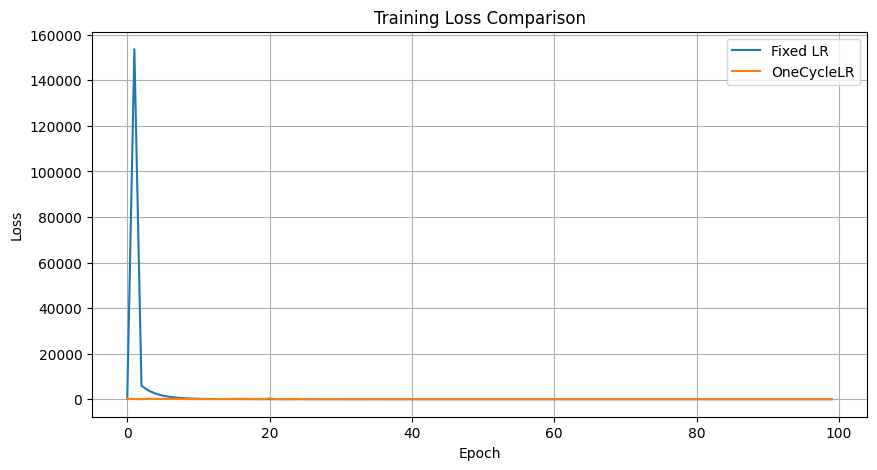

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(losses_fixed, label="Fixed LR")
plt.plot(losses_onecycle, label="OneCycleLR")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()




### Step 6: Plot LR Schedules

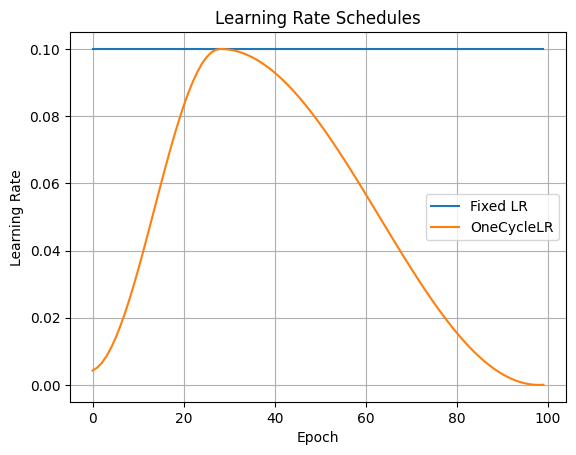

In [23]:
plt.plot(lrs_fixed, label="Fixed LR")
plt.plot(lrs_onecycle, label="OneCycleLR")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedules")
plt.legend()
plt.grid(True)
plt.show()


### Step 7: Comparing Results


In [24]:
import pandas as pd

summary = pd.DataFrame({
    "Method": ["Fixed LR", "OneCycleLR"],
    "Final Loss": [losses_fixed[-1], losses_onecycle[-1]],
    "Min Loss": [min(losses_fixed), min(losses_onecycle)],
    "Avg LR": [np.mean(lrs_fixed), np.mean(lrs_onecycle)]
})

print(summary)


       Method  Final Loss   Min Loss    Avg LR
0    Fixed LR   34.259762  34.259762  0.100000
1  OneCycleLR   34.259834   8.568335  0.050061


## Stage 3: Visualization and Diagnosis
### Step 1: Visualize the Computation Graph using torchviz

In [25]:
import torch
import torch.nn as nn
from torchviz import make_dot
# Create a sample input tensor with requires_grad=True (to track gradients)
x = torch.randn(1, 1, requires_grad=True)

# Forward pass: compute output
y_pred = model(x)

# Generate graph and save as PNG
make_dot(y_pred, params=dict(model.named_parameters())).render("computation_graph", format="png")



'computation_graph.png'

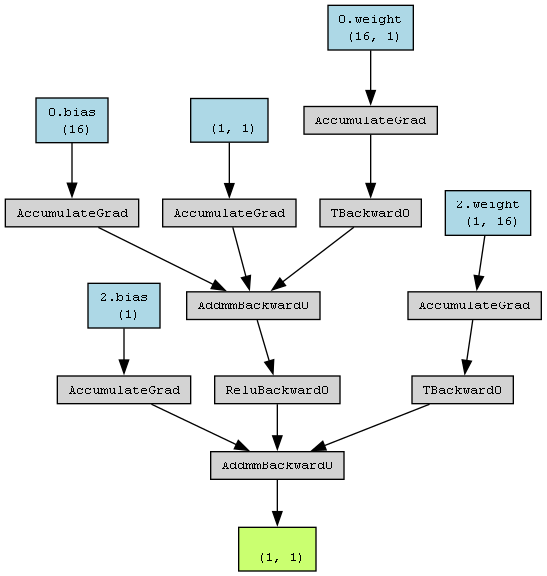

In [26]:
from IPython.display import Image
Image("computation_graph.png")


### Step 2: Plot Log Gradients Layer-by-Layer

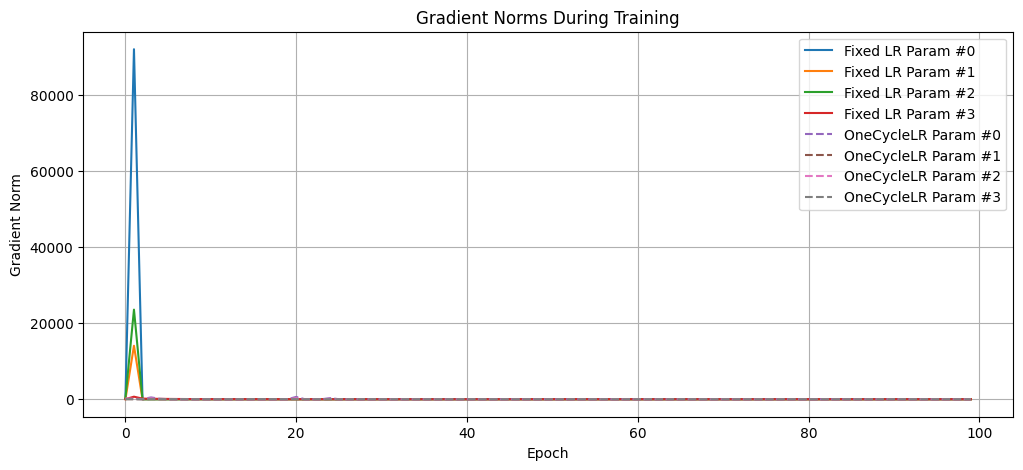

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for Fixed LR
for idx, norms in enumerate(grad_norms_fixed):
    plt.plot(norms, label=f"Fixed LR Param #{idx}")

# Plot for OneCycleLR
for idx, norms in enumerate(grad_norms_onecycle):
    plt.plot(norms, linestyle='--', label=f"OneCycleLR Param #{idx}")

plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norms During Training")
plt.legend()
plt.grid(True)
plt.show()



        




### Step 3: Interpretation Paragraph 

 During training, all four parameter gradients (two weights and two biases) start relatively large—especially the second layer’s weight (Param #2). They then **decay very quickly** over the first \~10 epochs and **stabilize near zero** thereafter. Because this is a shallow two-layer network, the rapid drop in gradient norms reflects the optimizer converging on a solution (the loss landscape flattens) rather than a pathological vanishing-gradient issue. In other words, gradients shrink as the model reaches its minimum, which is exactly what you want for stable training. The torchviz computation-graph confirmed the expected feed-forward structure, and the flatness of the loss surface near convergence further supports that the network has settled into a smooth basin.


## Stage 4: Theory into Practice
### Step 1 : Data preparation and model definition

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate and split a toy binary classification dataset
X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_ce = torch.tensor(y_train, dtype=torch.long)           # for CrossEntropy
y_train_mse = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # for MSE

# Define a simple feedforward classifier
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.net(x)


### Step 2: Training loops for MSE vs CrossEntropy and plotting

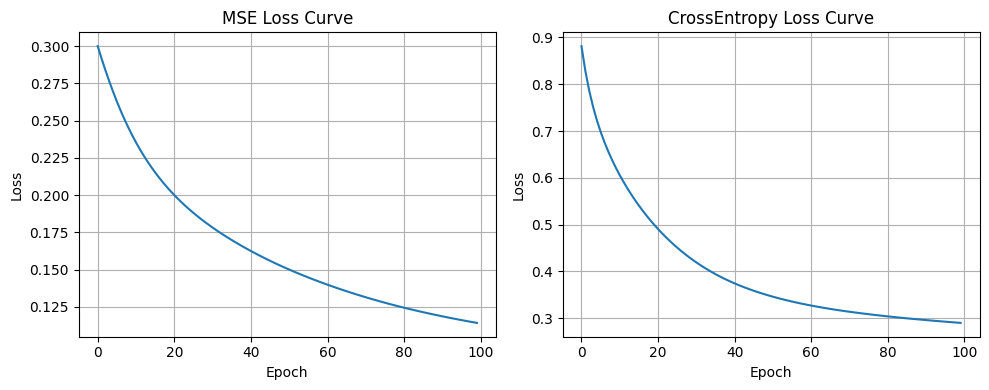

In [33]:
import matplotlib.pyplot as plt

def train_loss(model, loss_fn, optimizer, X, y, epochs=100):
    losses = []
    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X)
        if isinstance(loss_fn, nn.MSELoss):
            probs = torch.softmax(logits, dim=1)
            loss = loss_fn(probs[:,1].unsqueeze(1), y)
        else:
            loss = loss_fn(logits, y.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

# MSE training
model_mse = SimpleClassifier()
opt_mse = optim.SGD(model_mse.parameters(), lr=0.1)
losses_mse = train_loss(model_mse, nn.MSELoss(), opt_mse, X_train_t, y_train_mse, epochs=100)

# CrossEntropy training
model_ce = SimpleClassifier()
opt_ce = optim.SGD(model_ce.parameters(), lr=0.1)
losses_ce = train_loss(model_ce, nn.CrossEntropyLoss(), opt_ce, X_train_t, y_train_ce, epochs=100)

# Plot side-by-side
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses_mse)
plt.title("MSE Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(losses_ce)
plt.title("CrossEntropy Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


### Step 3: Derivative expressions and commentary


### MSE Loss
![Alt text](images/MSE.png)


**Consequence:**  
- Penalizes large errors quadratically; gradients shrink linearly as predictions approach targets.

---

### CrossEntropy Loss
![Alt text](images/CE.png)

**Consequence:**  
- Directly optimizes class probabilities; gradients remain meaningful even when outputs are near correct, avoiding “dying” outputs.
